### Solution 1

Import necessary libraries:

In [6]:
import numpy as np
import skimage.io as io
from matplotlib import pyplot as plt
import skimage.io
import skimage.transform
from skimage import color
from scipy.sparse.linalg import eigsh
from sklearn.cluster import KMeans
import cv2

Similarity matrix computation

In [7]:
def getImage(grayImg, scale):
    scaledImg = skimage.transform.rescale(grayImg , scale)  # Rescaling Image for Fast Computation
    img = scaledImg.reshape(-1)                             # Reshaping 2D Image into 1D Image for pixelwise operations
    return scaledImg, img

def Indexing(img):
    N = img.shape[0]                                        # N = Length of 1D Vector
    coordinateGrid = np.array(np.meshgrid(range(0, N), range(0, N), indexing='ij')) # Create a Coordinate Grid of size NxN
    MNIndex = np.array([coordinateGrid[0].ravel(), coordinateGrid[1].ravel()])      # Create another 2D Array of size square of size of Coordinate Grid
    MIndex, NIndex = MNIndex[0], MNIndex[1]                 # Get X-Indexing and Y-Indexing
    return MIndex, NIndex, N

def SimilarityMatrix(img, MIndex, NIndex, N):
    W = np.exp(-(img[MIndex]-img[NIndex])**2/2)    # Similarity Matrix using Intensity
    #W2 = np.exp( - (MIndex - NIndex) ** 2 / 2)      # Similarity Matrix using Distance
    #W = W1 * W2                                     # Similarity Matrix using both Intensity and Distance
    W = W.reshape(N , N)                            # Reshape 1D Similarity Matrix into 2D Array
    return W

def D_Matrix(W):
    D = np.sum(W, axis=1)
    D = np.diag(D)                   # Diagonal Element = Sum of all the elements in a particular row
    return D


### 2 segments image segmentation

In [8]:
def EigenVec_2seg(D, W, k, img):
    M = D - W                                       # Matrix M = D - W
    eigVal , eigVec = eigsh(M, k, which='SA')       # Finding Smallest 2 Eigen Value - Eigen Vector Pair
    norm = np.linalg.norm(eigVec, axis=1, keepdims=True)
    eigVec = eigVec / norm
    EigVec = eigVec[:,1].reshape(img.shape[0],img.shape[1])  # Selecting Second Smallest Eigenvalued Eigvector
    return EigVec

def PlotImage_2seg(scaledImg, EigVec):
    plt.figure()
    plt.subplot(121)
    plt.title('Input image')
    plt.imshow(scaledImg, cmap='gray')     # Plot Input Image
    plt.subplot(122)
    plt.imshow(EigVec > 0, cmap='gray')             # Plot Segmented Image
    plt.title('Segmented image')
    plt.show()
    return
    

### 3 segments image segmentation

In [9]:
def EigenVec_3seg(D, W, k, img):
    M = D - W                                       # Matrix M = D - W
    eigVal , eigVec = eigsh(M, k, which='SA')       # Finding Smallest 2 Eigen Value - Eigen Vector Pair
    norm = np.linalg.norm(eigVec, axis=1, keepdims=True)
    eigVec = eigVec / norm
    EigVec = eigVec[:,1:4]  # Selecting top 3 Eigenvectors
    return EigVec



def PlotImage_3seg(scaledImg, labels):
    plt.figure()
    plt.subplot(121)
    plt.title('Input image')
    plt.imshow(scaledImg, cmap='gray')     # Plot Input Image
    plt.subplot(122)
    plt.imshow(labels.reshape(scaledImg.shape[:2]), cmap='gray')             # Plot Segmented Image
    plt.title('Segmented image')
    plt.show()
    return

In [10]:
def Problem1(grayImg, scale):
    k = 20                                           # k = no. of Smallest Eignvalues to be extracted
    scaledImg, img = getImage(grayImg, scale)
    MIndex, NIndex, N = Indexing(img)
    W = SimilarityMatrix(img, MIndex, NIndex, N)
    D = D_Matrix(W)
    EigVec = EigenVec_2seg(D, W, k, scaledImg)
    PlotImage_2seg(scaledImg, EigVec)
    return

def Problem2(grayImg, scale):
    k = 20                                           # k = no. of Smallest Eignvalues to be extracted
    scaledImg, img = getImage(grayImg, scale)
    MIndex, NIndex, N = Indexing(img)
    W = SimilarityMatrix(img, MIndex, NIndex, N)
    D = D_Matrix(W)
    EigVec = EigenVec_3seg(D, W, k, scaledImg)
    
    # Use k-means clustering to get 3 segments
    kmeans = KMeans(n_clusters=3, random_state=0).fit(EigVec)
    labels = kmeans.labels_
    
    PlotImage_3seg(scaledImg, labels)
    return




Image 1 segmentation into 3 segments

C:\Users\nived\AppData\Roaming\Python\Python311\site-packages\sklearn\cluster\_kmeans.py:1416: FutureWarning: The default value of `n_init` will change from 10 to 'auto' in 1.4. Set the value of `n_init` explicitly to suppress the warning
  super()._check_params_vs_input(X, default_n_init=10)


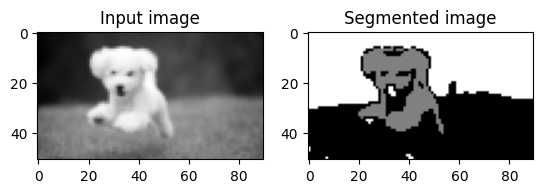

In [11]:
colorImg1 = io.imread("img1.jpeg")                           # Read Image from Path and Reshape it
grayImg1 = color.rgb2gray(colorImg1)                            # Color to Gray Conversion 
scale = 0.1                       
Problem2(grayImg1, scale)                                   # 3 segments

Image 2 segmentation

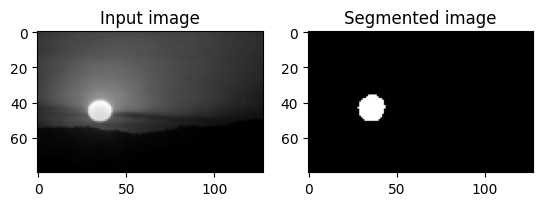

In [12]:
colorImg1 = io.imread("img2.jpeg")                           # Read Image from Path and Reshape it
grayImg1 = color.rgb2gray(colorImg1)                      # Color to Gray Conversion 
scale = 0.2  
Problem1(grayImg1, scale)                                   # 2 segments

Image 3 segmentation

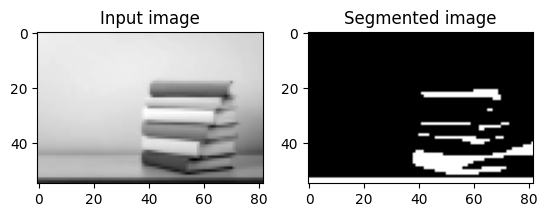

In [13]:
colorImg1 = io.imread("img3.jpeg")                           # Read Image from Path and Reshape it
grayImg1 = color.rgb2gray(colorImg1)                      # Color to Gray Conversion   
scale = 0.3  
Problem1(grayImg1, scale)                                   # 2 segments

Image 4 segmentation

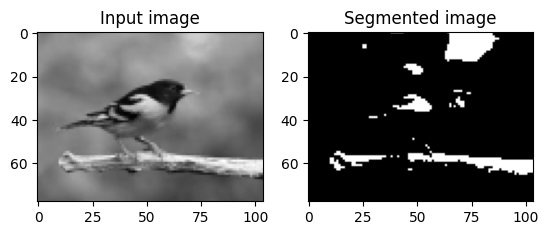

In [14]:
colorImg1 = io.imread("img4.jpeg")                           # Read Image from Path and Reshape it
grayImg1 = color.rgb2gray(colorImg1)                         # Color to Gray Conversion   
scale = 0.4  
Problem1(grayImg1, scale)                                   # 2 segments

### 1.b. color based segmentation using two similarity matrix

In [16]:
def getImage(colorImg, scale):
    # Check if the input image has multiple channels
    if len(colorImg.shape) == 3 and colorImg.shape[2] > 1:
        # Rescale each channel individually
        scaled_channels = [skimage.transform.rescale(colorImg[:, :, i], scale) for i in range(colorImg.shape[2])]
        scaledImg = np.stack(scaled_channels, axis=-1)  # Stack the rescaled channels
    else:
        # Rescale the single-channel image
        scaledImg = skimage.transform.rescale(colorImg, scale)
    img = scaledImg.reshape(-1, 3)  # Reshape 2D Image into 1D Image for pixelwise operations
    return scaledImg, img

def Indexing(img):
    N = img.shape[0]  # N = Length of 1D Vector
    coordinateGrid = np.array(np.meshgrid(range(0, N), range(0, N), indexing='ij'))  # Create a Coordinate Grid of size NxN
    MNIndex = np.array([coordinateGrid[0].ravel(), coordinateGrid[1].ravel()])  # Create another 2D Array of size square of size of Coordinate Grid
    MIndex, NIndex = MNIndex[0], MNIndex[1]  # Get X-Indexing and Y-Indexing
    return MIndex, NIndex, N

def SimilarityMatrix(img, MIndex, NIndex, N):
    img_flat = img.reshape(-1, 3)  # Flatten the image to compute pairwise similarities
    W = np.exp(-np.linalg.norm(img_flat[MIndex] - img_flat[NIndex], axis=1)**2 / (2 * (0.1 ** 2)))
    W = W.reshape(N, N)  # Reshape 1D Similarity Matrix into 2D Array
    return W

def D_Matrix(W):
    D = np.sum(W, axis=1)
    D = np.diag(D)  # Diagonal Element = Sum of all the elements in a particular row
    return D

def EigenVec_2seg(D, W, k, img):
    M = D - W  # Matrix M = D - W
    eigVal, eigVec = eigsh(M, k, which='SA')  # Finding Smallest 2 Eigen Value - Eigen Vector Pair
    norm = np.linalg.norm(eigVec, axis=1, keepdims=True)
    eigVec = eigVec / norm
    EigVec = eigVec[:, 1].reshape(img.shape[0], img.shape[1])  # Selecting Second Smallest Eigenvalued Eigvector
    return EigVec

def PlotImage_2seg(scaledImg, EigVec):
    plt.figure()
    plt.subplot(121)
    plt.title('Input image')
    plt.imshow(scaledImg)  # Plot Input Image
    plt.subplot(122)
    plt.imshow(EigVec > 0, cmap='gray')  # Plot Segmented Image
    plt.title('Segmented image')
    plt.show()
    return
    
def Problem1(colorImg, scale):
    k = 20  # k = no. of Smallest Eigenvalues to be extracted
    rotation = False
    noisy = False
    scaledImg, img = getImage(colorImg, scale, rotation, noisy)
    MIndex, NIndex, N = Indexing(img)
    W = SimilarityMatrix(img, MIndex, NIndex, N)
    D = D_Matrix(W)
    EigVec = EigenVec_2seg(D, W, k, scaledImg)
    PlotImage_2seg(scaledImg, EigVec)
    return



Scaled image shape: (51, 90, 3)


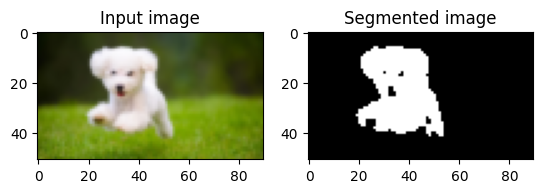

In [17]:
colorImg1 = io.imread("img1.jpeg")  # Read Image from Path and Reshape it
scale = 0.1
Problem1(colorImg1, scale)  # 2 segments

Scaled image shape: (40, 64, 3)


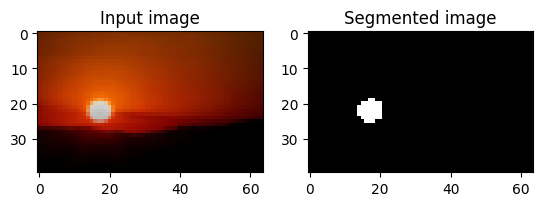

In [24]:
colorImg1 = io.imread("img2.jpeg")  # Read Image from Path and Reshape it
scale = 0.1
Problem1(colorImg1, scale)  # 2 segments

Scaled image shape: (18, 28, 3)


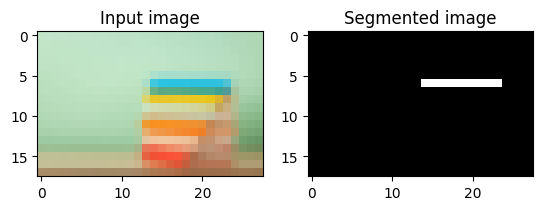

In [25]:
colorImg1 = io.imread("img3.jpeg")  # Read Image from Path and Reshape it
scale = 0.1
Problem1(colorImg1, scale)  # 2 segments

Scaled image shape: (58, 78, 3)


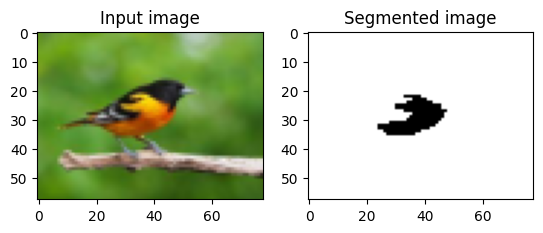

In [27]:
colorImg1 = io.imread("img4.jpeg")  # Read Image from Path and Reshape it
scale = 0.3
Problem1(colorImg1, scale)  # 2 segments

### 1.c. K-means based segmentation

In [18]:
k = [3,4,5,6]
def k_means(vectorized, k):
    criteria = (cv2.TERM_CRITERIA_EPS + cv2.TERM_CRITERIA_MAX_ITER, 10, 1.0)
    attempts=10
    ret,label,center=cv2.kmeans(vectorized,k,None,criteria,attempts,cv2.KMEANS_PP_CENTERS) 
    center = np.uint8(center)
    res = center[label.flatten()]
    result_image = res.reshape((img1.shape))
    return result_image

def read_img(original_image, k):
    #print(k)
    #print(img1.shape)
    vectorized = original_image.reshape((-1,3))
    #print(vectorized.shape)
    vectorized = np.float32(vectorized)
    result = []
    for i in range(len(k)):
        K = k[i]
        result.append(k_means(vectorized, K))
    return result

def plot_original(original_image):
    img1=cv2.cvtColor(original_image,cv2.COLOR_BGR2RGB)
    figure_size = 15
    plt.figure(figsize=(figure_size,figure_size))
    plt.subplot(1,2,1),plt.imshow(img1)
    plt.title('Original Image'), plt.xticks([]), plt.yticks([])
    plt.show()



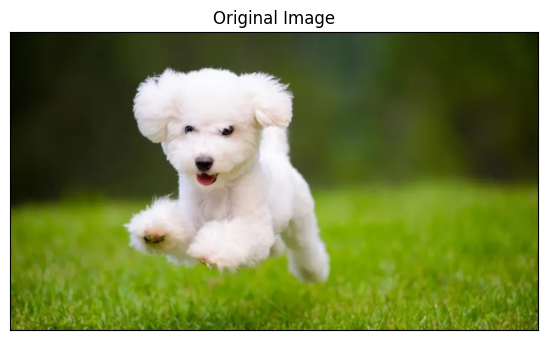

In [19]:
img1 = cv2.imread('img1.jpeg')
result = read_img(img1, k)
plot_original(img1)

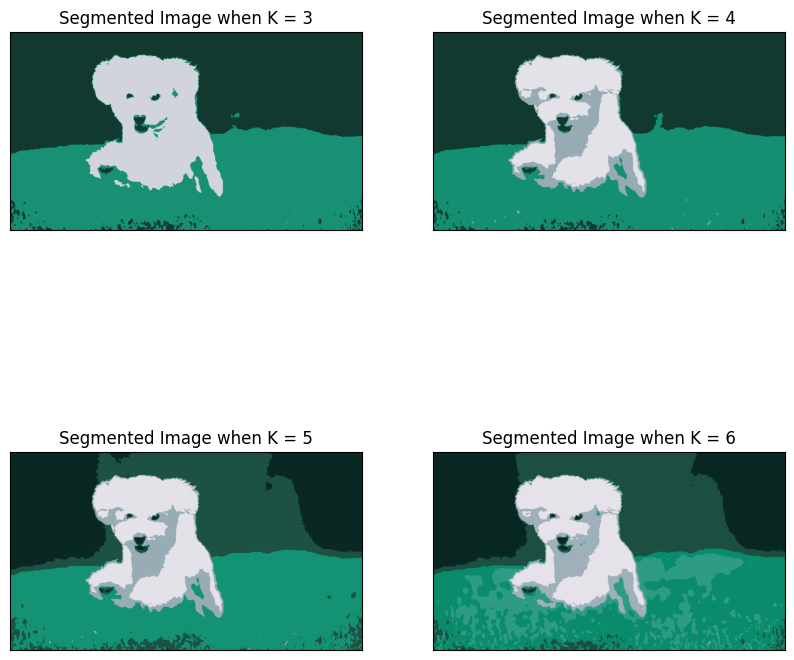

In [20]:
def plot_segments(result):
    figure_size = 10
    plt.figure(figsize=(figure_size,figure_size))
    for i in range(len(k)):
        plt.subplot(2,2,i+1),plt.imshow(result[i])
        plt.title('Segmented Image when K = %i' % k[i]), plt.xticks([]), plt.yticks([])

plot_segments(result)

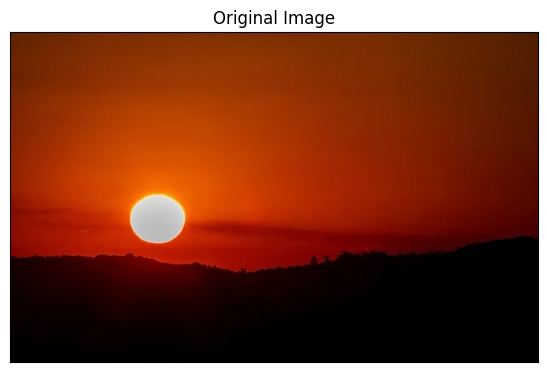

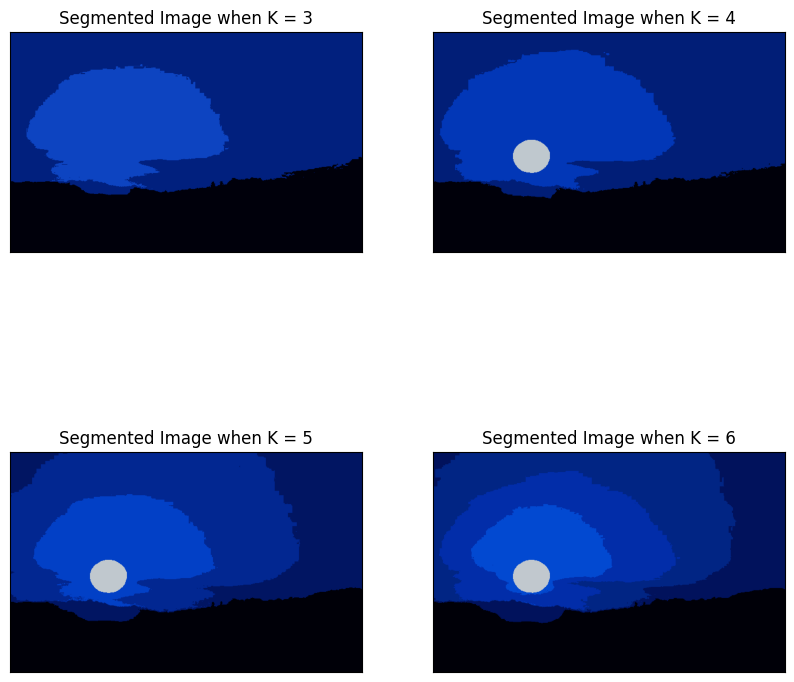

In [21]:
img1 = cv2.imread('img2.jpeg')
result = read_img(img1, k)
plot_original(img1)
plot_segments(result)

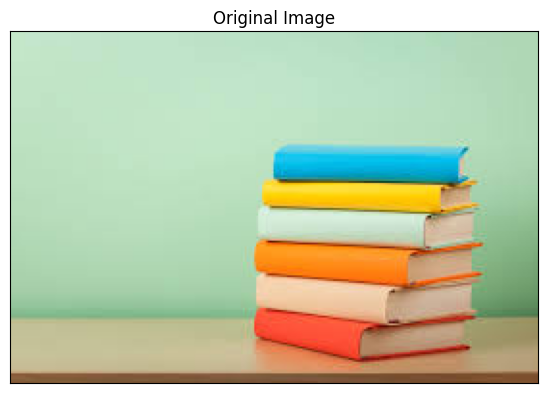

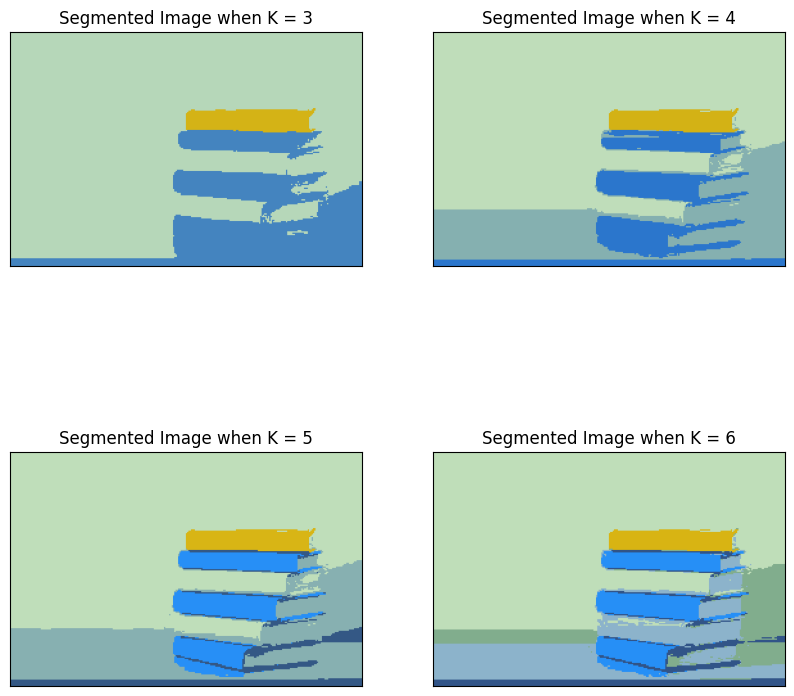

In [22]:
img1 = cv2.imread('img3.jpeg')
result = read_img(img1, k)
plot_original(img1)
plot_segments(result)

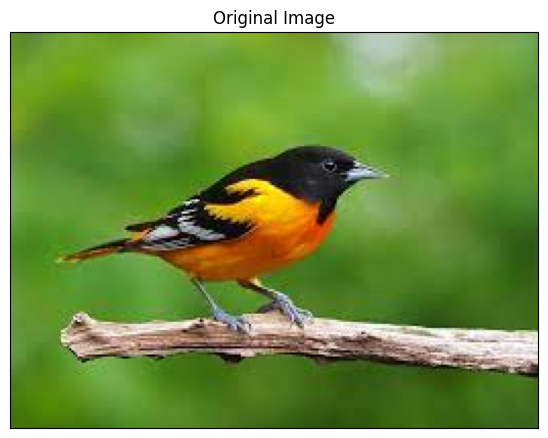

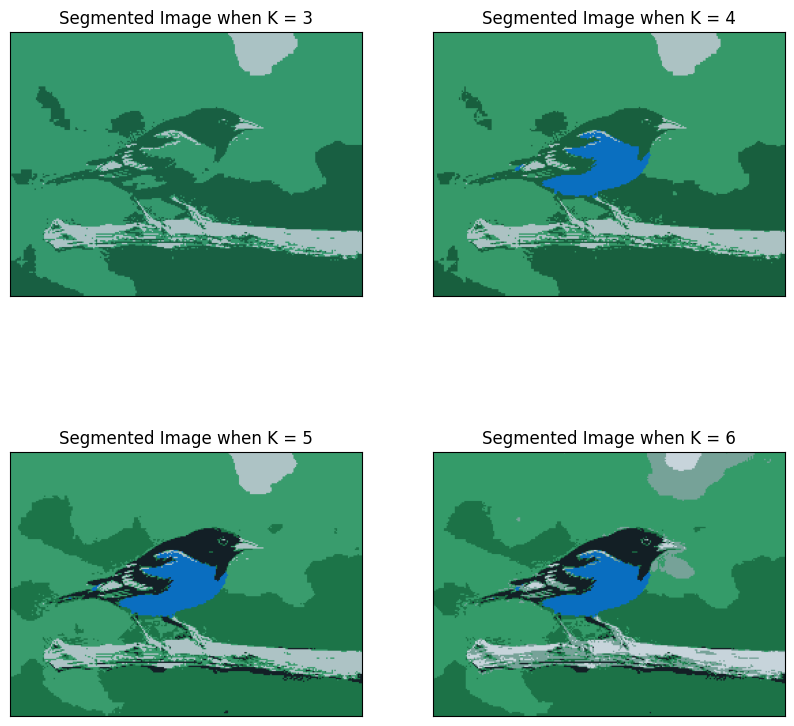

In [23]:
img1 = cv2.imread('img4.jpeg')
result = read_img(img1, k)
plot_original(img1)
plot_segments(result)